In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [2]:
class Mess3Process:
    def __init__(self):
        self.T_A = np.array([
            [0.765, 0.00375, 0.00375],
            [0.0425, 0.0675, 0.00375],
            [0.0425, 0.00375, 0.0675]
        ])

        self.T_B = np.array([
            [0.0675, 0.0425, 0.00375],
            [0.00375, 0.765, 0.00375],
            [0.00375, 0.0425, 0.0675]
        ])

        self.T_C = np.array([
            [0.0675, 0.00375, 0.0425],
            [0.00375, 0.0675, 0.0425],
            [0.00375, 0.00375, 0.765]
        ])

        self.T = self.T_A + self.T_B + self.T_C

        # Calculate stationary distribution
        eigenvalues, eigenvectors = np.linalg.eig(self.T.T)
        stationary_idx = np.argmin(np.abs(eigenvalues - 1))
        self.stationary_dist = np.real(eigenvectors[:, stationary_idx] /
                                       np.sum(eigenvectors[:, stationary_idx]))

        # Mappings
        self.idx_to_token = {0: 'A', 1: 'B', 2: 'C'}
        self.token_to_idx= {'A': 0, 'B': 1, 'C': 2}

    def generate_sequence(self, length):
        # Start state
        curr_state = np.random.choice(3, p=self.stationary_dist)
        states = [curr_state]
        tokens = []

        # Sample the rest of the states
        for _ in range(length):
            probs = np.concatenate([
                    self.T_A[curr_state],
                    self.T_B[curr_state],
                    self.T_C[curr_state],
            ])

            choice = np.random.choice(9, p=probs)
            token_idx = choice // 3 # 0->A, 1->B, 2->C
            next_state = choice % 3

            tokens.append(self.idx_to_token[token_idx])
            curr_state = next_state
            states.append(curr_state)

        return tokens, states

    def generate_all_contexts(self, max_length):
        contexts = [[]]
        for length in range(1, max_length + 1):
            new_contexts = []
            for context in contexts:
                if len(context) == length - 1:
                    for token in ['A', 'B', 'C']:
                        new_contexts.append(context + [token])
            contexts.extend(new_contexts)

        return contexts

    def get_belief_state(self, obss):
        if len(obss) == 0:
            return self.stationary_dist

        belief = self.stationary_dist.copy()
        for token in obss:
            if token == 'A':
                t = self.T_A
            elif token == 'B':
                t = self.T_B
            elif token == 'C':
                t = self.T_C

            belief_unnorm = np.dot(belief, t)
            belief = belief_unnorm / np.sum(belief_unnorm)

        return belief


    def calculate_all_belief_states(self, contexts):
        belief_states = []
        for context in contexts:
            belief_states.append(self.get_belief_state(context))
        return np.array(belief_states)


In [3]:
class Transformer(nn.Module):
    def __init__(self, vocab_size=3, model_dim=64, n_heads=1, n_layers=4):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 100, model_dim))

        class EncoderLayer(nn.Module):
            def __init__(self, model_dim, n_heads, ff_dim):
                super().__init__()
                self.self_attn = nn.MultiheadAttention(
                        embed_dim=model_dim,
                        num_heads=n_heads,
                        dropout=0.0,
                        batch_first=True
                )

                self.linear1 = nn.Linear(model_dim, ff_dim)
                self.activation = nn.ReLU()
                self.linear2 = nn.Linear(ff_dim, model_dim)

                self.norm1 = nn.LayerNorm(model_dim)
                self.norm2 = nn.LayerNorm(model_dim)

            def forward(self, x, x_mask=None):
                x1 = self.norm1(x)
                x1, _ = self.self_attn(x1, x1, x1, attn_mask=x_mask)
                x = x + x1

                x1 = self.norm2(x)
                x1 = self.linear1(x1)
                x1 = self.activation(x1)
                x1 = self.linear2(x1)
                x = x + x1

                return x

        self.layers = nn.ModuleList([
            EncoderLayer(
                    model_dim=model_dim,
                    n_heads=n_heads,
                    ff_dim=256
            ) for _ in range(n_layers)
        ])

        self.final_norm = nn.LayerNorm(model_dim)
        self.output_layer = nn.Linear(model_dim, vocab_size)

        self.residual_activations = []

    def forward(self, x, store_activations=False):
        # Create attention mask
        seq_len = x.size(1)
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
        mask = mask.to(x.device)

        if store_activations:
            self.residual_activations = []

        x = self.embedding(x)
        x = x + self.positional_encoding[:, :seq_len, :]

        residual_stream = x
        for layer in self.layers:
            residual_stream = layer(residual_stream, x_mask=mask)
            if store_activations:
                self.residual_activations.append(residual_stream.detach().clone())

        output = self.final_norm(residual_stream)
        logits = self.output_layer(output)

        return logits


In [4]:
def train(model, data_gen, n_epochs, batch_size, seq_len):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        n_batches = 0

        for _ in range(100):
            # Generate batch of sequences
            batch_inputs = []
            batch_targets = []

            for _ in range(batch_size):
                tokens, _ = data_gen.generate_sequence(seq_len + 1)
                input_seq = [data_gen.token_to_idx[t] for t in tokens[:-1]]
                target_seq = [data_gen.token_to_idx[t] for t in tokens[1:]]

                batch_inputs.append(input_seq)
                batch_targets.append(target_seq)

            inputs = torch.tensor(batch_inputs)
            targets = torch.tensor(batch_targets)

            # Forward pass
            logits = model(inputs)

            # Loss
            B, T, V = logits.shape
            logits_flat = logits.view(B*T, V)
            targets_flat = targets.view(B*T)
            loss = criterion(logits_flat, targets_flat)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / n_batches
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

    return model

In [5]:
def analyze_representations(model, data_gen, max_context_length):
    model.eval()

    # Generate all possible contexts and get ground truth beliefs
    contexts = data_gen.generate_all_contexts(max_context_length)
    ground_truth_beliefs = data_gen.calculate_all_belief_states(contexts)

    # Get residual stream activations for each context
    all_activations = []
    for context in contexts:
        if not context:
            continue

        input_tensor = torch.tensor([
            [data_gen.token_to_idx[t] for t in context]
        ])
        with torch.no_grad():
            model(input_tensor, store_activations=True)

        activation = model.residual_activations[-1][0, -1, :].numpy()
        all_activations.append(activation)

    ground_truth_beliefs = ground_truth_beliefs[1:] # First one is empty context
    activations_arr = np.array(all_activations)
    regression = LinearRegression()
    regression.fit(activations_arr, ground_truth_beliefs)

    projected_beliefs = regression.predict(activations_arr)

    return contexts[1:], ground_truth_beliefs, projected_beliefs, activations_arr

In [6]:
def visualize_simplex(ground_truth_beliefs, projected_beliefs):
    plt.figure(figsize=(12, 10))

    # Left plot: ground truth
    plt.subplot(1, 2, 1)

    # Convert to equilateral triangle coordinates
    x_gt = 0.5 * (2 * ground_truth_beliefs[:, 1] + ground_truth_beliefs[:, 2])
    y_gt = ground_truth_beliefs[:, 2] * np.sqrt(3) / 2

    plt.scatter(x_gt, y_gt, c=ground_truth_beliefs, s=10)
    plt.title("Ground truth")
        
    # Right plot: projection
    plt.subplot(1, 2, 2)
        
    # Find optimal affine transformation to match ground truth shape
    X = projected_beliefs[:, :2]  # First two dimensions
    y = np.column_stack([x_gt, y_gt])  # Target equilateral coordinates
    
    # Fit transformation from projection to equilateral
    reg = LinearRegression().fit(X, y)
    equil_coords = reg.predict(X)
        
    # Plot transformed projection
    plt.scatter(equil_coords[:, 0], equil_coords[:, 1], c=ground_truth_beliefs, s=10)
    plt.title("Residual stream projection")

    mse = np.mean((ground_truth_beliefs - projected_beliefs) ** 2)
    print(f"Mean squared error: {mse:.6f}")

In [7]:
MAX_CONTEXT_LENGTH = 8
mess3 = Mess3Process()
model = Transformer()

Mean squared error: 0.006365


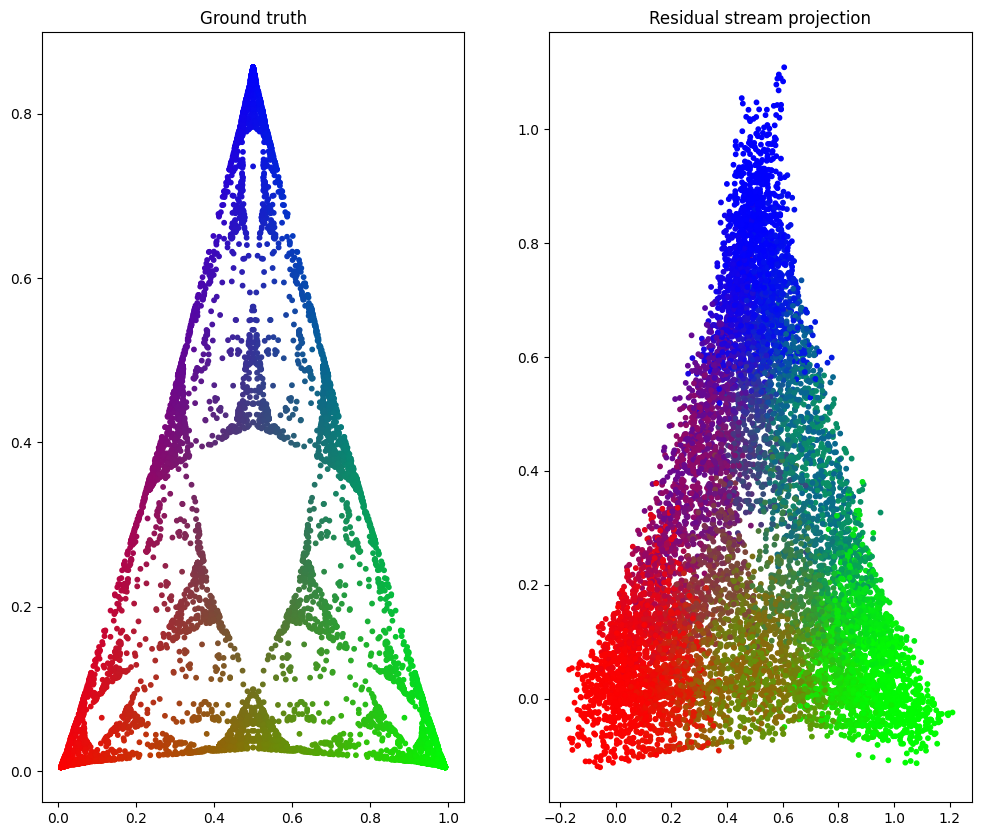

In [8]:
# Untrained projection
contexts, ground_truth_beliefs, projected_beliefs, _ = analyze_representations(
    model,
    mess3,
    max_context_length=MAX_CONTEXT_LENGTH
)

visualize_simplex(
    ground_truth_beliefs,
    projected_beliefs,
)

In [9]:
mess3 = Mess3Process()
model = Transformer()
model = train(model, mess3, 100, 64, 10)

Epoch 100/100, Loss: 0.8078


Mean squared error: 0.004251


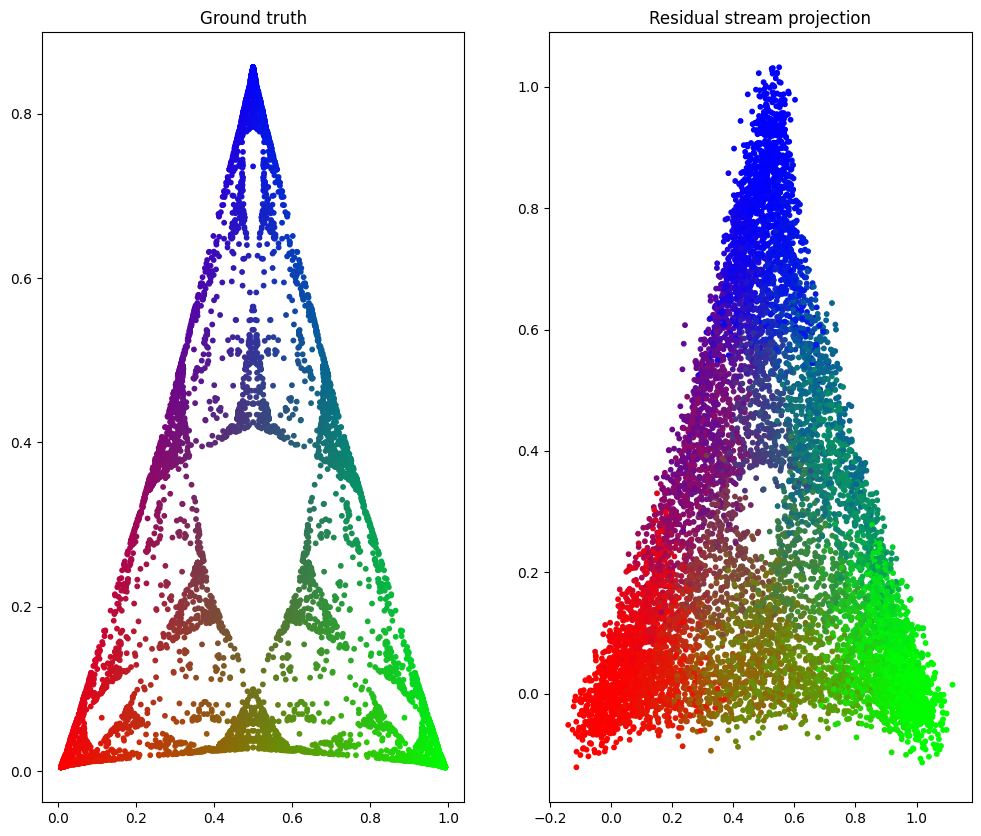

In [10]:
contexts, ground_truth_beliefs, projected_beliefs, _ = analyze_representations(
    model,
    mess3,
    max_context_length=MAX_CONTEXT_LENGTH
)

visualize_simplex(
    ground_truth_beliefs,
    projected_beliefs,
)

In [11]:
mess3 = Mess3Process()
model = Transformer()
model = train(model, mess3, 1000, 64, 10)

Epoch 100/1000, Loss: 0.8148
Epoch 200/1000, Loss: 0.8080
Epoch 300/1000, Loss: 0.8041
Epoch 400/1000, Loss: 0.8050
Epoch 500/1000, Loss: 0.8054
Epoch 600/1000, Loss: 0.8110
Epoch 700/1000, Loss: 0.8043
Epoch 800/1000, Loss: 0.8021
Epoch 900/1000, Loss: 0.7989
Epoch 1000/1000, Loss: 0.8020


Mean squared error: 0.000749


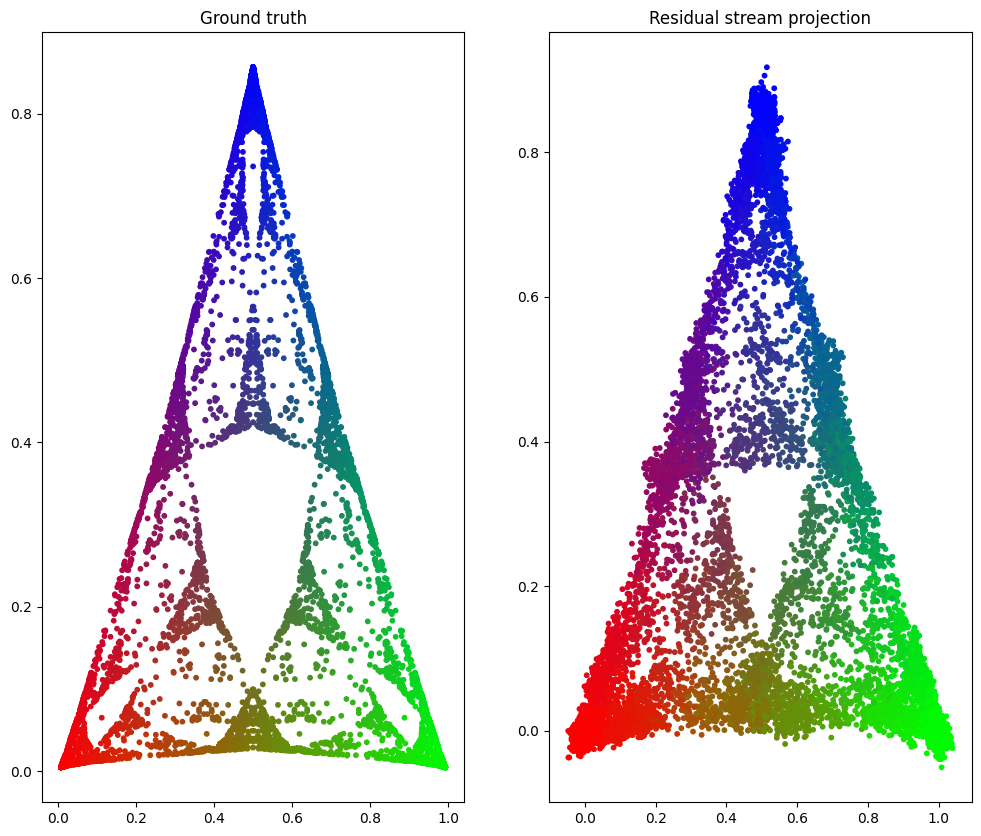

In [12]:
contexts, ground_truth_beliefs, projected_beliefs, _ = analyze_representations(
    model,
    mess3,
    max_context_length=MAX_CONTEXT_LENGTH
)

visualize_simplex(
    ground_truth_beliefs,
    projected_beliefs,
)